# **relation italicized text extraction with GRU & LSTM model and Bert embeding**

In [0]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential ,Model
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Dense,Embedding,Input,Dropout
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

# **plot_confusion_matrix definition**

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **read and split dataset**

In [0]:
df = pd.read_excel('SemEval2010_task8.xls')

In [5]:
#beart
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead
import pickle
import numpy as np
from torch import tensor
import json
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm

tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-6_H-512_A-8")
model = AutoModel.from_pretrained("google/bert_uncased_L-6_H-512_A-8")
def create_embeddings(doc):
  marked_text = "[CLS] " + doc + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = tensor([indexed_tokens])

  segments_tensors = tensor([segments_ids])

  encoded_layers, _= model(tokens_tensor, segments_tensors)
  return encoded_layers, tokenized_text

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.tokenize import sent_tokenize

sent_tokenized_data = []
for text in tqdm(df['sentences']):
  sents = sent_tokenize(text)
  temp = []
  for sent in sents:
    temp.append(sent.lower().replace(".",""))
  sent_tokenized_data.append(temp)

In [0]:
max_doc_sents = max([len(s) for s in sent_tokenized_data])

In [0]:
doc_sents = [len(s) for s in sent_tokenized_data]

In [10]:
embeddings = np.zeros((len(sent_tokenized_data),max_doc_sents,512))
i=0
for sample in tqdm(sent_tokenized_data):
  for j,sent in enumerate(sample):
    if len(sent.split(" ")) > 200:
      sent = sent[:1500]
    embeddings[i,j]=create_embeddings(sent)[0][0][0].detach().numpy()
  i+=1

In [0]:
codeOfLabals = []
for i in df['labels']:
    codeOfLabals.append(list(df.labels.unique()).index(i))

In [13]:
df.labels.unique()

array(['Component-Whole', 'Other', 'Instrument-Agency',
       'Member-Collection', 'Cause-Effect', 'Entity-Destination',
       'Content-Container', 'Message-Topic', 'Product-Producer',
       'Entity-Origin'], dtype=object)

In [0]:
labels = to_categorical(codeOfLabals, num_classes=len(df.labels.unique())) # from keras.utils.np_utils

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embeddings , labels, test_size=0.20, random_state=42)

# **create LSTM model**

In [0]:
inpu = Input((3,512))
bi = (Bidirectional(LSTM(256, dropout=0.7, recurrent_dropout=0.7)))(inpu)
drop= Dropout(0.5)(bi)
out = (Dense(labels.shape[1], activation='softmax'))(drop)
model = Model(inpu,out)

In [0]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['acc'])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 512)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,580,042
Trainable params: 1,580,042
Non-trainable params: 0
_________________________________________________________________


fit model

In [26]:
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 7s 170ms/step - loss: 2.0330 - acc: 0.2770 - val_loss: 1.7137 - val_acc: 0.3672
Epoch 2/30
40/40 [==============================] - 6s 151ms/step - loss: 1.7236 - acc: 0.3912 - val_loss: 1.5618 - val_acc: 0.4461
Epoch 3/30
40/40 [==============================] - 6s 151ms/step - loss: 1.6210 - acc: 0.4311 - val_loss: 1.5052 - val_acc: 0.4641
Epoch 4/30
40/40 [==============================] - 6s 150ms/step - loss: 1.5618 - acc: 0.4471 - val_loss: 1.4487 - val_acc: 0.4836
Epoch 5/30
40/40 [==============================] - 6s 152ms/step - loss: 1.5243 - acc: 0.4594 - val_loss: 1.4291 - val_acc: 0.4969
Epoch 6/30
40/40 [==============================] - 6s 151ms/step - loss: 1.4988 - acc: 0.4754 - val_loss: 1.4084 - val_acc: 0.4961
Epoch 7/30
40/40 [==============================] - 6s 152ms/step - loss: 1.4726 - acc: 0.4785 - val_loss: 1.4082 - val_acc: 0.4961
Epoch 8/30
40/40 [==============================] - 6s 151ms/step - loss: 1.

# **create GRU model**

In [0]:
inpu = Input((3,512))
bi = (Bidirectional(GRU(256, dropout=0.7, recurrent_dropout=0.7)))(inpu)
drop= Dropout(0.5)(bi)
out = (Dense(labels.shape[1], activation='softmax'))(drop)
model = Model(inpu,out)

In [0]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['acc'])

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3, 512)]          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 1,187,850
Trainable params: 1,187,850
Non-trainable params: 0
_________________________________________________________________


fit model

In [35]:
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 6s 148ms/step - loss: 2.0239 - acc: 0.2811 - val_loss: 1.6859 - val_acc: 0.3828
Epoch 2/30
40/40 [==============================] - 5s 136ms/step - loss: 1.7467 - acc: 0.3840 - val_loss: 1.5780 - val_acc: 0.4266
Epoch 3/30
40/40 [==============================] - 5s 135ms/step - loss: 1.6470 - acc: 0.4209 - val_loss: 1.5200 - val_acc: 0.4539
Epoch 4/30
40/40 [==============================] - 5s 134ms/step - loss: 1.5883 - acc: 0.4506 - val_loss: 1.4853 - val_acc: 0.4727
Epoch 5/30
40/40 [==============================] - 5s 134ms/step - loss: 1.5484 - acc: 0.4514 - val_loss: 1.4246 - val_acc: 0.4859
Epoch 6/30
40/40 [==============================] - 5s 134ms/step - loss: 1.5223 - acc: 0.4602 - val_loss: 1.4123 - val_acc: 0.4977
Epoch 7/30
40/40 [==============================] - 5s 133ms/step - loss: 1.5093 - acc: 0.4645 - val_loss: 1.4024 - val_acc: 0.5125
Epoch 8/30
40/40 [==============================] - 5s 134ms/step - loss: 1.

# **reports**

In [27]:
prediction_probas = model.predict(X_test) 
y_pred = [np.argmax(pred) for pred in prediction_probas]
y__test=np.argmax(y_test, axis=1)
labels_n = list(df.labels.unique())
print('classification_report\n'+classification_report(y__test, y_pred, digits=3))

classification_report
              precision    recall  f1-score   support

           0      0.620     0.579     0.598       197
           1      0.323     0.315     0.319       260
           2      0.478     0.434     0.455        99
           3      0.620     0.647     0.633       136
           4      0.717     0.714     0.715       199
           5      0.553     0.829     0.663       158
           6      0.750     0.646     0.694       130
           7      0.522     0.727     0.608       132
           8      0.563     0.379     0.453       153
           9      0.479     0.338     0.397       136

    accuracy                          0.552      1600
   macro avg      0.562     0.561     0.554      1600
weighted avg      0.553     0.552     0.546      1600



Confusion matrix, without normalization


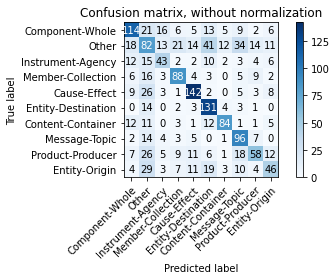

In [30]:
plot_confusion_matrix(y__test,np.array(y_pred),np.array(labels_n))
plt.show()
